<h3> clean up and make features from the price time series

In [2]:
import os
from pprint import pprint as pp
import pandas as pd
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import copy
import seaborn as sns
%matplotlib inline
os.getcwd()

'/home/ryan/Documents/insight_projects/steam_prices/data_analysis'

In [3]:
data_path = '/home/ryan/Documents/insight_projects/steam_price_data'
steamdb_fol = 'steamdb_jsons'
steamdb_path = os.path.join(data_path,steamdb_fol)
steamdb_fnames = os.listdir(steamdb_path)

In [4]:
'''from the steamdb jsons, first convert the raw, unformatted feature data'''
list_dict  = {'appid':list(),'fprice':list(),'iprice':list(), 'price_date':list(), 'formatted':list()}
for f in steamdb_fnames:
    appid = int(f.split('.')[0].split('_')[1])
    cur_file = os.path.join(steamdb_path,f)
    with open(cur_file) as json_file:
        json_data = json.load(json_file)
    cur_init = np.array(dict(json_data)[u'data'][ u'initial'])
    cur_final = np.array(dict(json_data)[u'data'][ u'final'])
    cur_formatted = dict(json_data)[u'data'][u'formatted']
    if cur_final.size > 0:
        cur_date = cur_init[:,0] * pow(10,-3)
        cur_init_just = cur_init[:,1]
        cur_final_just = cur_final[:,1]
    else:
        cur_date = None
        cur_init_just = None
        cur_final_just = None      
    list_dict['appid'].append(appid)
    list_dict['price_date'].append(cur_date)
    list_dict['iprice'].append(cur_init_just)
    list_dict['fprice'].append(cur_final_just)
    list_dict['formatted'].append(cur_formatted) #used the formatted data to make an the array

In [5]:
df = pd.DataFrame(list_dict)
df = df.fillna(value=np.nan)

<H4>TIME SERIES FOR PLOTTING ONLY

In [6]:
'''needs to be converted from a sample occurence to a plot (to do later)'''
sample = 2
dt = list_dict['price_date'][sample]
form_price = list_dict['formatted'][1]
min_timestamp = 1417120656
max_timestamp = 1442077561

obs_per_week = 4.0
week_sec = 7 * 24 * 60 * 60
step = week_sec / obs_per_week
timestamp_range = np.arange(min_timestamp,max_timestamp,step)

price_val = ['']*timestamp_range.size
#price_val[:] = np.nan

price_dates = [int(int(k) * pow(10,-3)) for k,v in form_price.iteritems()]


for item in price_dates:
    time_delta =  np.abs(item - timestamp_range)
    min_dif = np.argmin(time_delta)
    if min_dif.size == 1:
        dif_ix = int(min_dif)
    else:
        dif_ix = int(min_dif[0])
    price_val[dif_ix] = form_price[str(int(item * pow(10,3)))]

price_adjusted = price_val

for ix,val in enumerate(price_val):
    #print 'ix:'+ str(ix)
    #print 'val:'+ str(val)
    #print 'pa:' + str(price_adjusted[ix])
    if ix < len(price_val)-2:
        if price_adjusted[ix+1] == '' and price_adjusted[ix]['discount'] == 0:
            #print('trigger')
            price_adjusted[ix+1] = price_adjusted[ix]
        elif price_adjusted[ix+1] == '' and not price_adjusted[ix]['discount'] == 0:
            price_adjusted[ix+1] = price_adjusted[ix]
            price_adjusted[ix+1]['final'] = price_adjusted[ix+1]['initial']
            
    elif ix == len(price_val)-2:
        price_adjusted[ix+1] == price_adjusted[ix] #This will need to be adjusted, but 
price_adjusted[-1] = price_adjusted[-2] #not 100% right, but good for most cases.

<h4>SALES EVENTS TO BINARY - SALE OR NOT

In [181]:
def binary_list(form_price,bstep):
    '''
    turns the formatted prices into a list of booleans, each corresponding to a successive time periods
    indicating whether or not a sale occured in that time period
    form_price: the dictionary with discount values in it
    bstep: the size of the intervals (in seconds)
    '''
    if form_price == []:
        return []
    else:
        min_timestamp = 1417120656 #these numbers are drawn from the min and max values seen in the lists
        max_timestamp = 1442077561 #some timestamp ranges should be shorted, but I'll do with that later
        discount_dates= [int(int(k)*pow(10,-3)) for k,v in form_price.iteritems() if v['discount'] > 0] 
        binary_timestamp_range = np.arange(min_timestamp,max_timestamp,bstep)
        sale_occur = [0]*binary_timestamp_range.size

        for item in discount_dates:
            time_delta =  np.abs(item - binary_timestamp_range) #figure out how close the time_stamp is to each section of the list
            min_dif = np.argmin(time_delta) #use min_dif to figure out closes
            if min_dif.size == 1: #just in case there are two equa-distant close bins
                dif_ix = int(min_dif)
            else:
                dif_ix = int(min_dif[0])
            sale_occur[dif_ix] =  1
        
        bool_and_ts = [binary_timestamp_range,sale_occur]
        return bool_and_ts

In [176]:
'''apply function'''
week_sec = 7 * 24 * 60 * 60
bstep = week_sec * 2
df['sale_bool_all'] = df.formatted.apply(binary_list, args=(bstep,)) #includes holiday sales

<h4>Remove Common Sales Dates

In [9]:
'''first, identify common days by histogram'''
df.head()


,appid,formatted,fprice,iprice,price_date,sale_bool
0,2430,[],NaN,NaN,NaN,[]
1,297750,"{u'1434047268000': {u'discount': 25, u'initial...","[39.99, 29.99, 39.99, 19.99, 39.99]","[39.99, 39.99, 39.99, 39.99, 39.99]","[1417120656.0, 1434047268.0, 1434994431.0, 144...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,19080,"{u'1434049315000': {u'discount': 75, u'initial...","[9.99, 2.49, 9.99]","[9.99, 9.99, 9.99]","[1417120656.0, 1434049315.0, 1434996542.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,278850,"{u'1417513376000': {u'discount': 50, u'initial...","[4.99, 2.49, 4.99, 2.49, 4.99, 1.49, 4.99]","[4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99]","[1417120656.0, 1417513376.0, 1417545207.0, 141...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,367260,"{u'1431104712000': {u'discount': 0, u'initial'...","[5.39, 5.99, 4.01, 5.99, 6.29, 6.99, 5.24, 6.99]","[5.99, 5.99, 5.99, 5.99, 6.99, 6.99, 6.99, 6.99]","[1430513702.0, 1431104712.0, 1434045990.0, 143...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ..."


In [167]:
def make_sd_list(df_column_format):
    '''
    expects a pandas data series, with items in the "format" dictionary
    returns a list of lists, where each internal list contains the dates of sales
    '''
    out_sale_date_list = list()
    for item in df_column_format:
        if not item == []:
            cur_discount_dates= [int(int(k)*pow(10,-3)) for k,v in item.iteritems() if v['discount'] > 0]
        else:
            cur_discount_dates = []
        out_sale_date_list.append(cur_discount_dates)
    return out_sale_date_list

sales_date_list = make_sd_list(df.formatted)
# for item in df.formatted:
#     if not item == []:
#         cur_discount_dates= [int(int(k)*pow(10,-3)) for k,v in item.iteritems() if v['discount'] > 0]
#     else:
#         cur_discount_dates = []
#     sale_date_list.append(cur_discount_dates)

In [105]:
'''make histogram'''
min_ts = 1417120656
extra_day = (290 - (max_ts - min_ts) / (60.*60*24)) * 60.*60*24 #this needs to be made cleaner/clearer, but basically
#I'm just adding an extra day + some second to make the bins perfectly equal to 2 days
max_ts = 1442077561 + extra_day
merged_sd_list = list(itertools.chain(*sale_date_list)) #merged_sd_list is the flattened list of sales dates
merged_sd_list = np.array(merged_sd_list)
bin_size = 1 * 60 * 60 * 24
print bin_size
bin_count = 1+(max_ts - min_ts) / bin_size
#np.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)[source]
bins = np.linspace(min_ts,max_ts, endpoint= True, num = bin_count)
ncount, hbins = np.histogram(merged_sd_list, bins)



86400


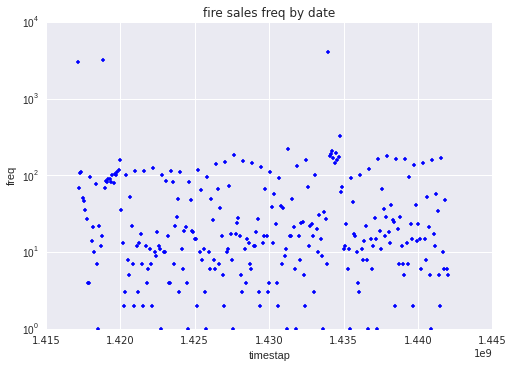

In [114]:
'''fire sale frequency by date. Most common ones are holiday sales, can be removed
outliers in the 1000+ count are obvious holiday sales"
'''
#p_bin = (hbins[:-1] - min_ts)  / (60.*60*24)  + 1
plt.plot(hbins[:-1],ncount,'b.')
plt.ylabel('freq')
plt.xlabel('timestap')
plt.title('fire sales freq by date')
plt.yscale('log')

In [107]:
fs2dbins = pd.DataFrame({'bin_start':hbins[:-1], 'bin_end':hbins[1:],'freq':ncount})
fs2dbins.sort('freq', ascending = False)
#explorations sale; Nov 26 - Dec 2, 1416960000:1417478400
#christmas sale: December 18th - January 2nd 1418860800:1420156800
#summer sale: June 6th - 21 1433203200: 1434844800

,bin_end,bin_start,freq
195,1434055056,1433968656,4076
20,1418935056,1418848656,3175
0,1417207056,1417120656,3036
204,1434832656,1434746256,326
164,1431376656,1431290256,221
198,1434314256,1434227856,210
201,1434573456,1434487056,195
197,1434227856,1434141456,188
122,1427747856,1427661456,186
241,1438029456,1437943056,181


 <h4>use these dates to exclude sales from the normal sales times

In [130]:

exclude_dates = {'explorations sale 2014':{'start':1416960000,'end':1417478400},
                'christmas sale 2014': {'start':1418860800,'end':1420156800},
                'summer sale 2015':{'start':1433203200,'end':1434844800}}


In [154]:
#df['formatted_no_holiday'] = df.formatted

def check_holiday(timestamp, exclude_dates):
    exclude = False
    for k,v in exclude_dates.iteritems():
        if v['start'] <= timestamp <= v['end']:
            exclude = True
    return exclude


def remove_holiday(formatted, exclude_dates):
    if not formatted == []:
        fdict = formatted
        fdict_popped = copy.deepcopy(fdict)
        for k,v in fdict.iteritems():
            ktrans = int(int(k)*pow(10,-3))
            if check_holiday(ktrans,exclude_dates):
                fdict_popped.pop(k)
        if fdict_popped == {}:
            fdict_popped = []
        return fdict_popped
    else:
        return []


In [155]:
df['formatted_no_holiday'] = df.formatted.apply(remove_holiday, args =(exclude_dates,))

In [182]:
'''apply function'''
week_sec = 7 * 24 * 60 * 60
bstep = week_sec * 2
df['sale_bool_no_holiday'] = df.formatted_no_holiday.apply(binary_list, args=(bstep,))

In [178]:
no_holiday_sts = make_sd_list(df.formatted_no_holiday) #no holiday sales times (sts)
df['saledates_no_holiday'] = no_holiday_sts

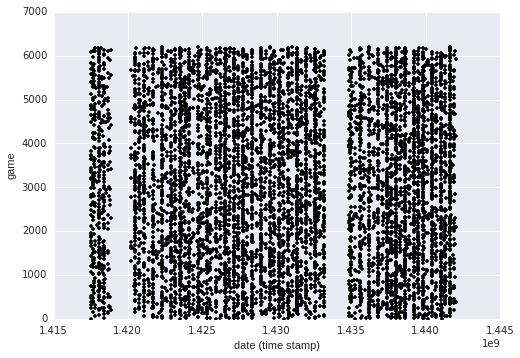

In [171]:
'''plot sale occurence date by appid. Empty bands are removed holiday sales'''
fig,ax = plt.subplots(1,1)
for i,v in enumerate(no_holiday_sts):
    if not v == []:
        y = [i]*len(v)
        ax.plot(v,y,'k.')
        
ax.set_ylabel('game')
ax.set_xlabel('date (time stamp)')
    

In [173]:
df

,appid,formatted,fprice,iprice,price_date,sale_bool,formatted_no_holiday,sale_bool_no_holiday,saledates_no_holiday
0,2430,[],NaN,NaN,NaN,[],[],[],[]
1,297750,"{u'1434047268000': {u'discount': 25, u'initial...","[39.99, 29.99, 39.99, 19.99, 39.99]","[39.99, 39.99, 39.99, 39.99, 39.99]","[1417120656.0, 1434047268.0, 1434994431.0, 144...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1440522322000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1440176720]
2,19080,"{u'1434049315000': {u'discount': 75, u'initial...","[9.99, 2.49, 9.99]","[9.99, 9.99, 9.99]","[1417120656.0, 1434049315.0, 1434996542.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1434996542000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[]
3,278850,"{u'1417513376000': {u'discount': 50, u'initial...","[4.99, 2.49, 4.99, 2.49, 4.99, 1.49, 4.99]","[4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99]","[1417120656.0, 1417513376.0, 1417545207.0, 141...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1417513376000': {u'discount': 50, u'initial...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1417513376]
4,367260,"{u'1430513702000': {u'discount': 10, u'initial...","[5.39, 5.99, 4.01, 5.99, 6.29, 6.99, 5.24, 6.99]","[5.99, 5.99, 5.99, 5.99, 6.99, 6.99, 6.99, 6.99]","[1430513702.0, 1431104712.0, 1434045990.0, 143...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","{u'1435856718000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1435268707, 1441127115, 1430513702]"
5,251970,"{u'1423505188000': {u'discount': 80, u'initial...","[4.99, 0.99, 4.99]","[4.99, 4.99, 4.99]","[1417120656.0, 1423505188.0, 1424109986.0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{u'1423505188000': {u'discount': 80, u'initial...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1423505188]
6,293860,"{u'1420223901000': {u'discount': 0, u'initial'...","[5.99, 2.09, 5.99, 1.79, 5.99, 1.49, 5.99]","[5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99]","[1417120656.0, 1418928906.0, 1420223901.0, 142...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","{u'1420223901000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",[1425920831]
7,2390,"{u'1417543929000': {u'discount': 0, u'initial'...","[2.49, 4.99, 2.49, 4.99, 2.49, 4.99, 2.99, 4.99]","[4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99]","[1417120656.0, 1417543929.0, 1418927005.0, 142...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1417543929000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1437671143]
8,291910,"{u'1418928920000': {u'discount': 35, u'initial...","[15.99, 19.99, 12.99, 19.99, 9.99, 19.99]","[19.99, 19.99, 19.99, 19.99, 19.99, 19.99]","[1417120656.0, 1417545533.0, 1418928920.0, 142...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1420223767000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[]
9,231160,"{u'1434048401000': {u'discount': 60, u'initial...","[7.49, 14.99, 7.49, 14.99, 5.99, 14.99]","[14.99, 14.99, 14.99, 14.99, 14.99, 14.99]","[1417120656.0, 1417544698.0, 1418928369.0, 142...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1420223282000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[]


In [8]:
'''not used now'''
min_iprice = list()
min_fprice = list()
for item in df.iprice:
    min_iprice_descent = make_descend(item)
    min_iprice.append(min_iprice_descent)

for item in df.fprice:
    min_fprice_descent = make_descend(item)
    min_fprice.append(min_fprice_descent)

In [9]:
df['min_fprice'] = min_fprice
df['min_iprice'] = min_iprice

In [11]:
df['min_iprice_var'] = df['min_iprice'].apply(np.var)

In [14]:
intercepts = list()
slopes = list()
for x,y in zip(df['price_date'],df['min_iprice']):
    if abs(np.sum(x)) >0: 
        linstat = stats.linregress(x,y)
    else:
        linstat = (np.nan,np.nan)
    intercepts = np.append(intercepts,linstat[1])
    slopes = np.append(slopes,linstat[0])
    
df['min_iprice_slope'] = slopes
df['min_iprice_intercept'] = intercepts

In [15]:
df['min_iprice_slope'][df['min_iprice_var'] > np.spacing(2)]


16    -1.750405e-10
36    -3.165598e-10
53    -3.138265e-10
54    -2.321009e-10
61    -2.397682e-10
88    -5.443083e-10
92    -3.925511e-09
95    -4.291506e-09
104   -4.191228e-10
105   -4.110342e-09
108   -5.194943e-11
128   -1.299366e-10
152   -4.291427e-09
164   -1.161534e-09
166   -4.529244e-10
...
6081   -5.184942e-10
6088   -2.721694e-10
6097   -1.613740e-10
6102   -3.067520e-10
6103   -2.500268e-10
6127   -9.647339e-10
6135   -7.045586e-10
6142   -7.129163e-11
6144   -1.457928e-10
6145   -2.052250e-11
6178   -1.922564e-10
6180   -8.569364e-10
6184   -1.574378e-10
6186   -3.916915e-10
6190   -5.701188e-10
Name: min_iprice_slope, Length: 621, dtype: float64

In [183]:
df.to_pickle('df_steam_db.pkl')

In [180]:
df

,appid,formatted,fprice,iprice,price_date,sale_bool,formatted_no_holiday,sale_bool_no_holiday,saledates_no_holiday,sale_bool_all
0,2430,[],NaN,NaN,NaN,[],[],[],[],[]
1,297750,"{u'1434047268000': {u'discount': 25, u'initial...","[39.99, 29.99, 39.99, 19.99, 39.99]","[39.99, 39.99, 39.99, 39.99, 39.99]","[1417120656.0, 1434047268.0, 1434994431.0, 144...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1440522322000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1440176720],"[[1417120656, 1418330256, 1419539856, 14207494..."
2,19080,"{u'1434049315000': {u'discount': 75, u'initial...","[9.99, 2.49, 9.99]","[9.99, 9.99, 9.99]","[1417120656.0, 1434049315.0, 1434996542.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1434996542000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],"[[1417120656, 1418330256, 1419539856, 14207494..."
3,278850,"{u'1417513376000': {u'discount': 50, u'initial...","[4.99, 2.49, 4.99, 2.49, 4.99, 1.49, 4.99]","[4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99]","[1417120656.0, 1417513376.0, 1417545207.0, 141...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1417513376000': {u'discount': 50, u'initial...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1417513376],"[[1417120656, 1418330256, 1419539856, 14207494..."
4,367260,"{u'1430513702000': {u'discount': 10, u'initial...","[5.39, 5.99, 4.01, 5.99, 6.29, 6.99, 5.24, 6.99]","[5.99, 5.99, 5.99, 5.99, 6.99, 6.99, 6.99, 6.99]","[1430513702.0, 1431104712.0, 1434045990.0, 143...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","{u'1435856718000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1435268707, 1441127115, 1430513702]","[[1417120656, 1418330256, 1419539856, 14207494..."
5,251970,"{u'1423505188000': {u'discount': 80, u'initial...","[4.99, 0.99, 4.99]","[4.99, 4.99, 4.99]","[1417120656.0, 1423505188.0, 1424109986.0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{u'1423505188000': {u'discount': 80, u'initial...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1423505188],"[[1417120656, 1418330256, 1419539856, 14207494..."
6,293860,"{u'1420223901000': {u'discount': 0, u'initial'...","[5.99, 2.09, 5.99, 1.79, 5.99, 1.49, 5.99]","[5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99]","[1417120656.0, 1418928906.0, 1420223901.0, 142...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","{u'1420223901000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",[1425920831],"[[1417120656, 1418330256, 1419539856, 14207494..."
7,2390,"{u'1417543929000': {u'discount': 0, u'initial'...","[2.49, 4.99, 2.49, 4.99, 2.49, 4.99, 2.99, 4.99]","[4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99, 4.99]","[1417120656.0, 1417543929.0, 1418927005.0, 142...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1417543929000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1437671143],"[[1417120656, 1418330256, 1419539856, 14207494..."
8,291910,"{u'1418928920000': {u'discount': 35, u'initial...","[15.99, 19.99, 12.99, 19.99, 9.99, 19.99]","[19.99, 19.99, 19.99, 19.99, 19.99, 19.99]","[1417120656.0, 1417545533.0, 1418928920.0, 142...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1420223767000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],"[[1417120656, 1418330256, 1419539856, 14207494..."
9,231160,"{u'1434048401000': {u'discount': 60, u'initial...","[7.49, 14.99, 7.49, 14.99, 5.99, 14.99]","[14.99, 14.99, 14.99, 14.99, 14.99, 14.99]","[1417120656.0, 1417544698.0, 1418928369.0, 142...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{u'1420223282000': {u'discount': 0, u'initial'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],"[[1417120656, 1418330256, 1419539856, 14207494..."
